In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = "data/noemoticon_preprocessed.csv"
df = pd.read_csv(file_path)
print(df.info())

##already do following steps
##removing HTML and brackets.
# df["text"] = df["text"].apply(helper.denoise_text)
#Expands abbreviations, e.g. "can't" → "cannot", "I'm" → "I am"
# df["text"] = df["text"].apply(helper.expand_contractions)
#Remove @someone and email addresses from text
# df["text"] = df["text"].apply(helper.remove_mentions_and_emails)
#apply futher
# df["text"] = df["text"].apply(helper.remove_non_ascii_in_text)

Using device: cuda
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597267 entries, 0 to 1597266
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1597267 non-null  int64 
 1   text      1597267 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


In [3]:
label_mapping = {0: 0, 4: 1} #把原始的 0/4 映射成 0/1，实现 二分类任务
df["polarity"] = df["polarity"].map(label_mapping)

In [4]:
df["tokens"] = df["text"].apply(word_tokenize) #base on the experience, directly use nftk's word_tokenize

In [5]:
counter = Counter()
for tokens in df["tokens"]:  
    counter.update(tokens)

In [6]:
max_vocab_size = 50000  
# 限制词汇表大小，防止低频词占用太多空间 
# based on 
#   1. Words appearing > 5 times: 50289 
#   2. Percentage of low-frequency words: 88.30%
word2idx = {"<PAD>": 0, "<UNK>": 1}  # 预留特殊标记
for i, (word, freq) in enumerate(counter.most_common(max_vocab_size - 2), start=2):
    word2idx[word] = i

In [7]:
# **将文本转换为索引**
def tokens_to_ids(tokens, word2idx):
    return [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]

df["token_ids"] = df["tokens"].apply(lambda x: tokens_to_ids(x, word2idx))

In [8]:
# **训练/测试数据集划分**
train_x, test_x, train_y, test_y = train_test_split(
    df["token_ids"].tolist(), df["polarity"].tolist(),
    test_size=0.2, random_state=34, stratify=df["polarity"]
)

In [9]:
# **PyTorch Dataset**
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(t, dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [10]:
# **Padding Collate Function**
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=word2idx['<PAD>'])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded.to(device), labels.to(device)

In [11]:
# **创建 DataLoader**
batch_size = 128
train_dataset = TextDataset(train_x, train_y)
test_dataset = TextDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [12]:
# Define the model with configurable RNN type
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, rnn_type='none', num_layers=1):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn_type = rnn_type.lower()
        
        if self.rnn_type == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        else:
            self.rnn = None
        
        self.fc = nn.Linear(hidden_dim * 2 if self.rnn else embed_dim, 2) #2 class only
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        if self.rnn:
            x, _ = self.rnn(x)
            x = self.dropout(x[:, -1, :])  # Take last time step output
        else:
            x = x.mean(dim=1)  # Simple mean pooling for RNN=None
        x = self.fc(x)
        return x

In [ ]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        for inputs, targets in train_progress:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            train_loss += loss.item()

            # 更新 tqdm 显示的训练损失
            train_progress.set_postfix(loss=f"{loss.item():.4f}")

        train_loss /= len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation accuracy
        model.eval()
        all_preds, all_labels = [], []
        val_loss = 0
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        with torch.no_grad():
            for inputs, targets in val_progress:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

                # 更新 tqdm 显示的验证损失
                val_progress.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = accuracy_score(all_labels, all_preds)
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Validation Loss={val_loss:.4f}, Validation Acc={val_acc:.4f}")
    
    return history


In [14]:
# Function to plot results
def plot_results(histories):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # 获取epoch数量（假设所有模型训练epoch数相同）
    num_epochs = len(next(iter(histories.values()))['train_loss'])
    x_ticks = list(range(1, num_epochs + 1))  # X轴从1开始到num_epochs
    
    # Plot Loss
    for model_type, history in histories.items():
        axes[0].plot(x_ticks, history['train_loss'], label=f'Train Loss ({model_type})')
        axes[0].plot(x_ticks, history['val_loss'], label=f'Val Loss ({model_type})', linestyle='dashed')
    axes[0].set_xticks(x_ticks)  # 强制设置整数刻度
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Comparison')
    axes[0].legend()
    
    # Plot Accuracy
    for model_type, history in histories.items():
        axes[1].plot(x_ticks, [x * 100 for x in history['train_acc']], label=f'Train Acc ({model_type})')
        axes[1].plot(x_ticks, [x * 100 for x in history['val_acc']], label=f'Val Acc ({model_type})', linestyle='dashed')
    axes[1].set_xticks(x_ticks)  # 强制设置整数刻度
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Validation Accuracy Comparison')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

Training model with NONE...



Epoch 1/10: Train Loss=0.5792, Train Acc=0.7118, Validation Loss=0.5162, Validation Acc=0.7640



Epoch 2/10: Train Loss=0.4951, Train Acc=0.7774, Validation Loss=0.4832, Validation Acc=0.7842



Epoch 3/10: Train Loss=0.4743, Train Acc=0.7904, Validation Loss=0.4715, Validation Acc=0.7913



Epoch 4/10: Train Loss=0.4644, Train Acc=0.7962, Validation Loss=0.4656, Validation Acc=0.7948



Epoch 5/10: Train Loss=0.4582, Train Acc=0.7997, Validation Loss=0.4621, Validation Acc=0.7974



Epoch 6/10: Train Loss=0.4540, Train Acc=0.8022, Validation Loss=0.4599, Validation Acc=0.7985



Epoch 7/10: Train Loss=0.4509, Train Acc=0.8041, Validation Loss=0.4585, Validation Acc=0.7988



Epoch 8/10: Train Loss=0.4482, Train Acc=0.8055, Validation Loss=0.4574, Validation Acc=0.8001



Epoch 9/10: Train Loss=0.4461, Train Acc=0.8067, Validation Loss=0.4568, Validation Acc=0.8000



Epoch 10/10: Train Loss=0.4445, Train Acc=0.8079, Validation Loss=0.4565, Validation Acc=0.8000


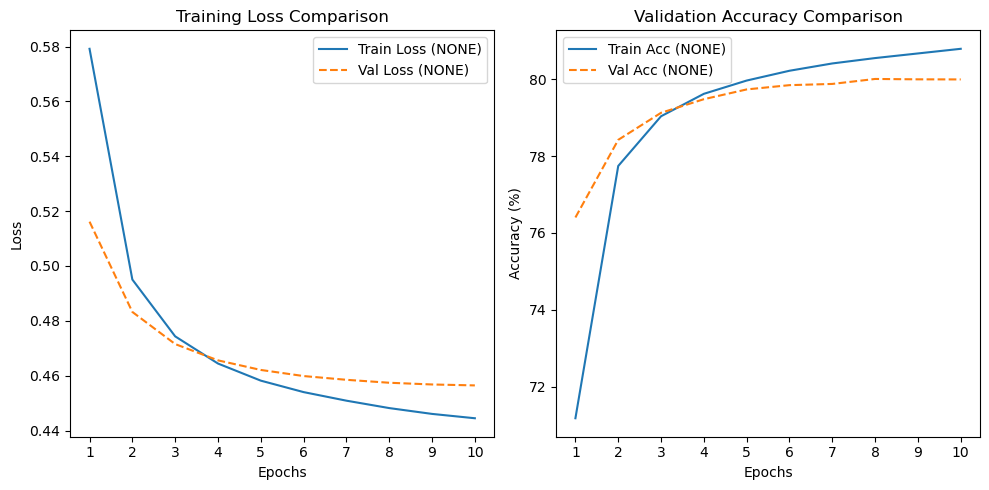

Training model with GRU...



Epoch 1/10: Train Loss=0.5017, Train Acc=0.7487, Validation Loss=0.4423, Validation Acc=0.7961



Epoch 2/10: Train Loss=0.4307, Train Acc=0.8045, Validation Loss=0.4232, Validation Acc=0.8068



Epoch 3/10: Train Loss=0.4083, Train Acc=0.8164, Validation Loss=0.4040, Validation Acc=0.8170



Epoch 4/10: Train Loss=0.3930, Train Acc=0.8244, Validation Loss=0.3948, Validation Acc=0.8220



Epoch 5/10: Train Loss=0.3810, Train Acc=0.8308, Validation Loss=0.3915, Validation Acc=0.8239



Epoch 6/10: Train Loss=0.3715, Train Acc=0.8353, Validation Loss=0.3837, Validation Acc=0.8278



Epoch 7/10: Train Loss=0.3632, Train Acc=0.8397, Validation Loss=0.3800, Validation Acc=0.8309



Epoch 8/10: Train Loss=0.3561, Train Acc=0.8435, Validation Loss=0.3761, Validation Acc=0.8320



Epoch 9/10: Train Loss=0.3497, Train Acc=0.8468, Validation Loss=0.3751, Validation Acc=0.8333



Epoch 10/10: Train Loss=0.3438, Train Acc=0.8502, Validation Loss=0.3710, Validation Acc=0.8355


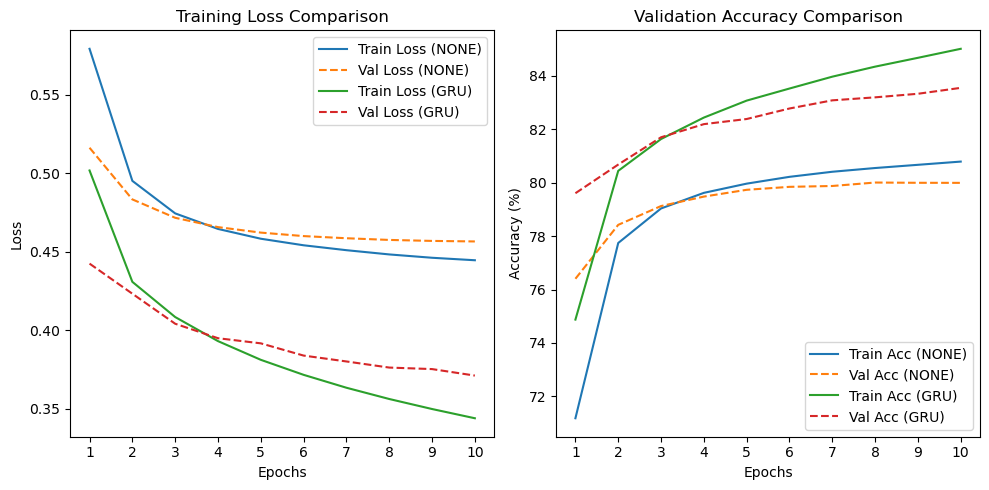

Training model with LSTM...



Epoch 1/10: Train Loss=0.5040, Train Acc=0.7514, Validation Loss=0.4535, Validation Acc=0.7889



Epoch 2/10: Train Loss=0.4342, Train Acc=0.8030, Validation Loss=0.4208, Validation Acc=0.8082



Epoch 3/10: Train Loss=0.4100, Train Acc=0.8163, Validation Loss=0.4066, Validation Acc=0.8161



Epoch 4/10: Train Loss=0.3940, Train Acc=0.8244, Validation Loss=0.3968, Validation Acc=0.8209



Epoch 5/10: Train Loss=0.3816, Train Acc=0.8305, Validation Loss=0.3951, Validation Acc=0.8239



Epoch 6/10: Train Loss=0.3721, Train Acc=0.8355, Validation Loss=0.3882, Validation Acc=0.8260



Epoch 7/10: Train Loss=0.3638, Train Acc=0.8394, Validation Loss=0.3818, Validation Acc=0.8304



Epoch 8/10: Train Loss=0.3569, Train Acc=0.8431, Validation Loss=0.3780, Validation Acc=0.8315



Epoch 9/10: Train Loss=0.3505, Train Acc=0.8461, Validation Loss=0.3767, Validation Acc=0.8329



Epoch 10/10: Train Loss=0.3446, Train Acc=0.8494, Validation Loss=0.3740, Validation Acc=0.8337


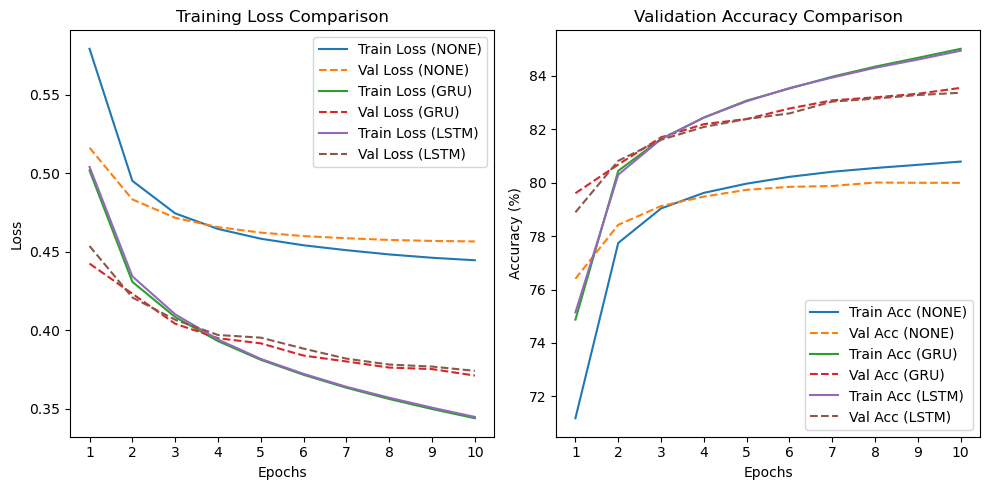

In [16]:
histories = {}

config = {
    'embed_dim': 128,
    'hidden_dim': 128,
    'num_epochs': 10
}

for rnn_type in ['none', 'gru', 'lstm']:
    print(f"Training model with {rnn_type.upper()}...")
    model = RNNClassifier(max_vocab_size, config['embed_dim'], config['hidden_dim'], rnn_type)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    history = train_model(model, train_loader, test_loader, criterion, optimizer, config['num_epochs'], device)
    histories[rnn_type.upper()] = history
    
    plot_results(histories)